In [ ]:
#Random Forest

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.7min remaining:  2.6min
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:  1.7min remaining:  1.2min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.7min finished



Cross-Validation Results:
Average Accuracy: 0.9344 (±0.0037)
Average Precision: 0.9450 (±0.0062)
Average Recall: 0.9227 (±0.0112)
Average F1: 0.9336 (±0.0041)
Average ROC AUC: 0.9843 (±0.0010)

Aggregated Evaluation:
              precision    recall  f1-score   support

      Normal       0.92      0.95      0.94      8190
       Event       0.94      0.92      0.93      8192

    accuracy                           0.93     16382
   macro avg       0.93      0.93      0.93     16382
weighted avg       0.93      0.93      0.93     16382



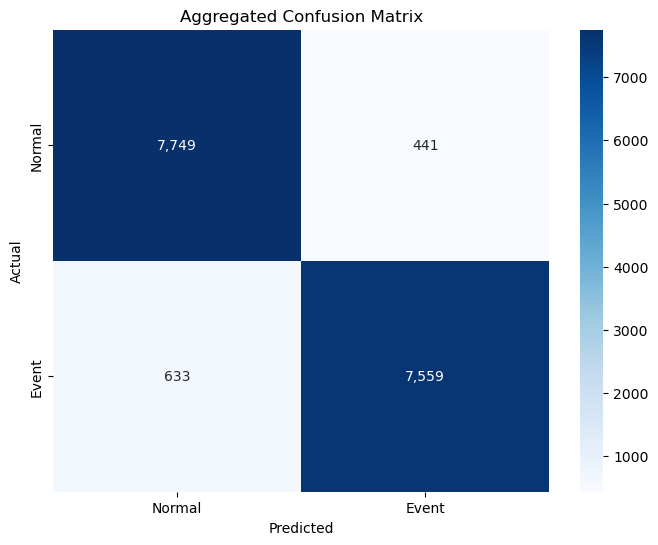

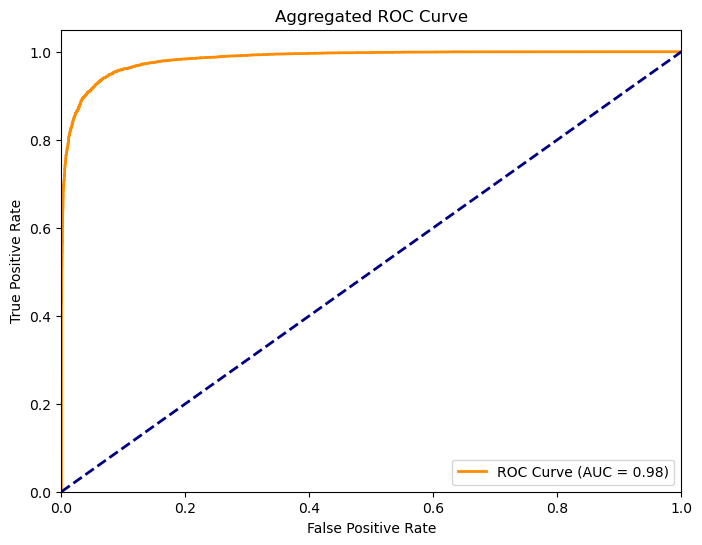

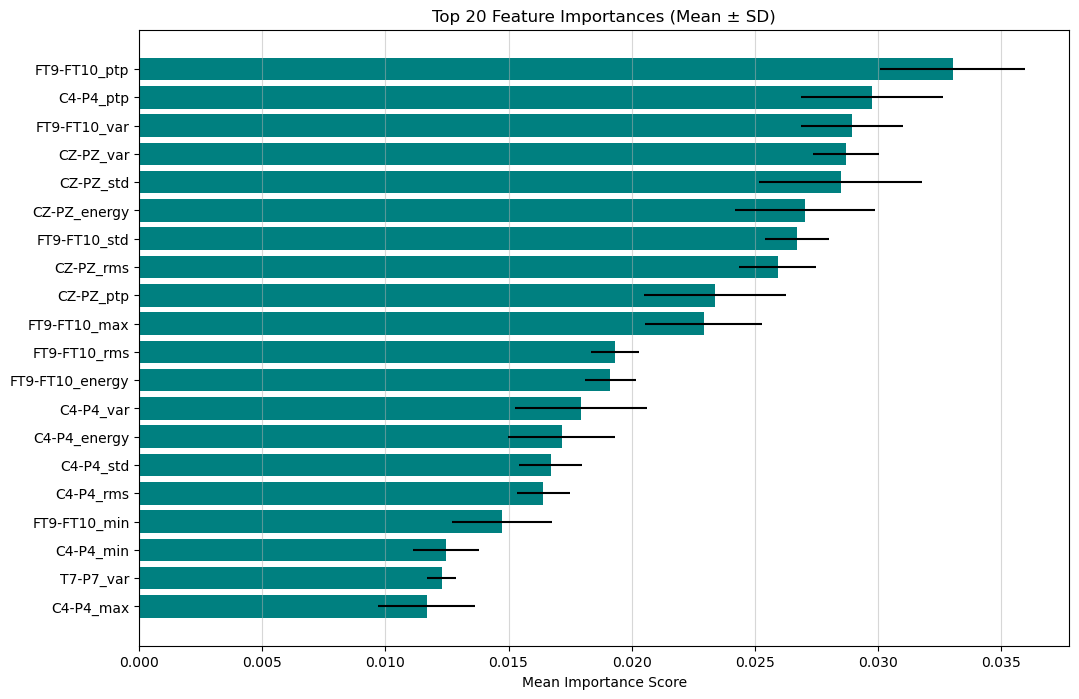

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, confusion_matrix,
                             classification_report, roc_curve)
from sklearn.utils import class_weight
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import Parallel, delayed

# Load features
df = pd.read_csv('D:\\MOOC.fi\\Jupyter\\EEG\\Dataset\\timefeature_data.csv').dropna()

# Configuration
N_SPLITS = 5
N_JOBS = -1
N_ESTIMATORS = 1000
RANDOM_STATE = None

# Prepare data
X = df.drop('target', axis=1)
y = df['target']
features = X.columns.tolist()

# Initialize Stratified K-Fold
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)

# Initialize metrics storage
metrics = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'roc_auc': []
}

# Storage for final aggregation
all_y_test = []
all_y_pred = []
all_y_proba = []
feature_importances = []

def process_fold(train_idx, test_idx, X, y):
    """Process one fold with full CPU utilization"""
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    # Class weights
    classes = np.unique(y_train)
    weights = class_weight.compute_class_weight('balanced', classes=classes, y=y_train)
    weight_dict = {cls: w for cls, w in zip(classes, weights)}
    
    # Model training
    rf = RandomForestClassifier(
        n_estimators=N_ESTIMATORS,
        max_depth=15,
        class_weight=weight_dict,
        n_jobs=N_JOBS,
        verbose=2,
        random_state=RANDOM_STATE,
        criterion='gini'
    )
    rf.fit(X_train, y_train)
    
    # Predictions
    y_pred = rf.predict(X_test)
    y_proba = rf.predict_proba(X_test)[:, 1]
    
    return {
        'y_test': y_test,
        'y_pred': y_pred,
        'y_proba': y_proba,
        'importances': rf.feature_importances_
    }

# Parallel processing of folds
results = Parallel(n_jobs=min(N_SPLITS, N_JOBS), verbose=10)(
    delayed(process_fold)(train_idx, test_idx, X, y)
    for train_idx, test_idx in skf.split(X, y)
)

# Aggregate results
for result in results:
    all_y_test.extend(result['y_test'])
    all_y_pred.extend(result['y_pred'])
    all_y_proba.extend(result['y_proba'])
    feature_importances.append(result['importances'])
    
    # Calculate fold metrics
    metrics['accuracy'].append(accuracy_score(result['y_test'], result['y_pred']))
    metrics['precision'].append(precision_score(result['y_test'], result['y_pred']))
    metrics['recall'].append(recall_score(result['y_test'], result['y_pred']))
    metrics['f1'].append(f1_score(result['y_test'], result['y_pred']))
    metrics['roc_auc'].append(roc_auc_score(result['y_test'], result['y_proba']))

# Calculate average feature importances
mean_importances = np.mean(feature_importances, axis=0)
std_importances = np.std(feature_importances, axis=0)

# Print metrics
print("\nCross-Validation Results:")
print(f"Average Accuracy: {np.mean(metrics['accuracy']):.4f} (±{np.std(metrics['accuracy']):.4f})")
print(f"Average Precision: {np.mean(metrics['precision']):.4f} (±{np.std(metrics['precision']):.4f})")
print(f"Average Recall: {np.mean(metrics['recall']):.4f} (±{np.std(metrics['recall']):.4f})")
print(f"Average F1: {np.mean(metrics['f1']):.4f} (±{np.std(metrics['f1']):.4f})")
print(f"Average ROC AUC: {np.mean(metrics['roc_auc']):.4f} (±{np.std(metrics['roc_auc']):.4f})")

# Final evaluation on all predictions
print("\nAggregated Evaluation:")
print(classification_report(all_y_test, all_y_pred, target_names=['Normal', 'Event']))

# Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(all_y_test, all_y_pred)
sns.heatmap(cm, annot=True, fmt=',d', cmap='Blues',
            xticklabels=['Normal', 'Event'],
            yticklabels=['Normal', 'Event'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Aggregated Confusion Matrix')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(all_y_test, all_y_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2,
         label=f'ROC Curve (AUC = {roc_auc_score(all_y_test, all_y_proba):.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Aggregated ROC Curve')
plt.legend(loc="lower right")
plt.show()

# Feature Importance
indices = np.argsort(mean_importances)[-20:]
plt.figure(figsize=(12, 8))
plt.title('Top 20 Feature Importances (Mean ± SD)')
plt.barh(range(len(indices)), mean_importances[indices], xerr=std_importances[indices],
         align='center', color='teal', ecolor='black')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Mean Importance Score')
plt.grid(axis='x', alpha=0.5)
plt.show()

In [ ]:
#KNN

=== Best Model Test Set Performance ===
Accuracy: 0.9759

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      1638
           1       0.98      0.97      0.98      1639

    accuracy                           0.98      3277
   macro avg       0.98      0.98      0.98      3277
weighted avg       0.98      0.98      0.98      3277


=== Cross-Validated Metrics ===
Average Accuracy: 0.9781 (±0.0024)
Average Precision: 0.9781
Average Recall: 0.9781
Average F1-Score: 0.9781

=== Optimal Hyperparameters ===
{'knn__metric': 'manhattan', 'knn__n_neighbors': 1, 'knn__weights': 'uniform'}


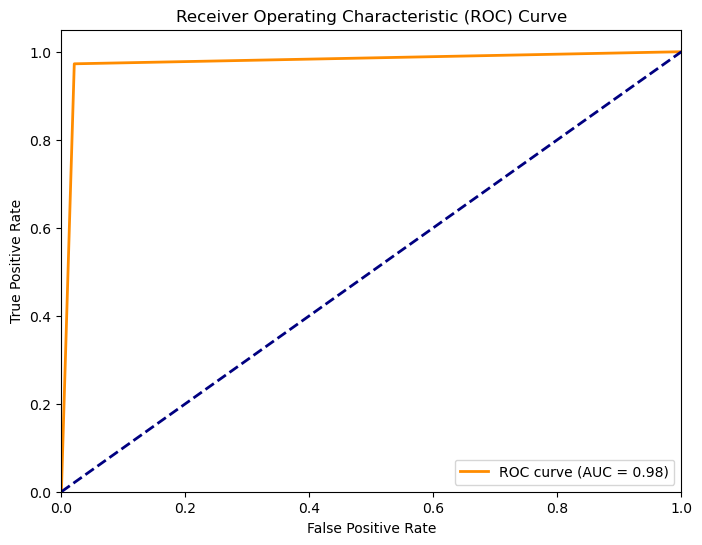

<Figure size 800x600 with 0 Axes>

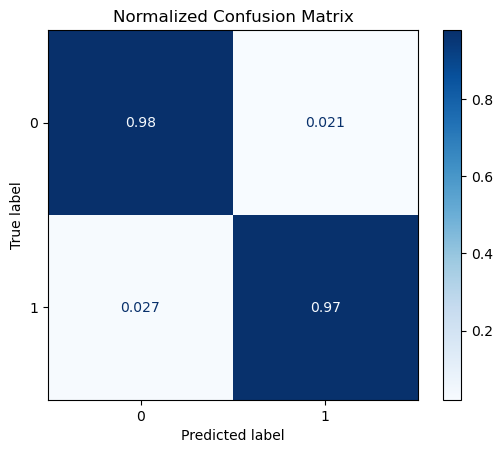

In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, ConfusionMatrixDisplay

# Load dataset
data = pd.read_csv('D:\\MOOC.fi\\Jupyter\\EEG\\Dataset\\timefeature_data.csv')
X = data.drop('target', axis=1)
y = data['target']

# Split into train-test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2,
    random_state=42,
    stratify=y
)

# Create processing pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Crucial for KNN performance
    ('knn', KNeighborsClassifier(n_jobs=-1))  # Utilize all CPU cores
])

# Hyperparameter grid for tuning
param_grid = {
    'knn__n_neighbors': list(range(1, 10, 2)),  # Test various neighborhood sizes
    'knn__weights': ['uniform', 'distance'],  # Test weighting schemes
    'knn__metric': ['euclidean', 'manhattan', 'minkowski']  # Different distance metrics
}

# Configure grid search with stratified k-fold
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=0),
    scoring='accuracy',
    n_jobs=-1  # Utilize all CPU cores for parallel processing
)

# Perform hyperparameter tuning
grid_search.fit(X_train, y_train)

# Get best model
best_model = grid_search.best_estimator_

# Test set evaluation
y_pred = best_model.predict(X_test)
print("=== Best Model Test Set Performance ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Cross-validated metrics
print("\n=== Cross-Validated Metrics ===")
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
scoring = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']
cv_results = cross_validate(
    best_model,
    X, y,
    cv=cv,
    scoring=scoring,
    n_jobs=-1
)

print(f"Average Accuracy: {cv_results['test_accuracy'].mean():.4f} (±{cv_results['test_accuracy'].std():.4f})")
print(f"Average Precision: {cv_results['test_precision_macro'].mean():.4f}")
print(f"Average Recall: {cv_results['test_recall_macro'].mean():.4f}")
print(f"Average F1-Score: {cv_results['test_f1_macro'].mean():.4f}")

# Display best parameters
print("\n=== Optimal Hyperparameters ===")
print(grid_search.best_params_)

y_proba = best_model.predict_proba(X_test)
n_classes = len(best_model.classes_)

# For binary classification
fpr, tpr, _ = roc_curve(y_test, y_proba[:, 1])
roc_auc = auc(fpr, tpr)
    
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, 
         label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()
# Enhanced Confusion Matrix Visualization
plt.figure(figsize=(8, 6))
ConfusionMatrixDisplay.from_estimator(
    best_model,
    X_test, y_test,
    display_labels=best_model.classes_,
    cmap=plt.cm.Blues,
    normalize='true'
)
plt.title('Normalized Confusion Matrix')
plt.show()

In [ ]:
#SVM

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import (accuracy_score, confusion_matrix, classification_report, 
                             roc_curve, auc, roc_auc_score)

# -------------------------------
# Load your EEG time-domain features
# -------------------------------
# Assumes 'eeg_features.csv' has feature columns and a 'label' column.
data = pd.read_csv('D:\\MOOC.fi\\Jupyter\\EEG\\Dataset\\timefeature_data.csv')

# Separate features and target labels
X = data.drop('target', axis=1)
y = data['target']

# -------------------------------
# Split data into training and testing sets
# -------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0, stratify=y
)

# -------------------------------
# Set up Grid Search with K-Fold Cross Validation
# -------------------------------
# SVM with probability=True to enable ROC curve plotting
svc = SVC(probability=True, random_state=0)

# Define parameter grid: try various kernels and optionally adjust C and gamma.
param_grid = {
    'kernel': ['rbf', 'poly'],
    'C': [10],
    'gamma': ['scale', 'auto']
}

# Using 5-fold cross validation
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)

grid_search = GridSearchCV(svc, param_grid, cv=cv, n_jobs=-1, scoring='accuracy')
grid_search.fit(X_train, y_train)

print("Best Parameters from GridSearchCV:")
print(grid_search.best_params_)

# -------------------------------
# Evaluate the Best Model on Test Set
# -------------------------------
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("\nTest Set Accuracy: {:.2f}%".format(accuracy * 100))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# -------------------------------
# Plot Confusion Matrix using Seaborn
# -------------------------------
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

# -------------------------------
# Plot ROC Curve
# -------------------------------
# For ROC curve, ensure a binary classification problem.
# For multi-class, consider one-vs-rest strategy.
if len(np.unique(y)) == 2:
    # Get probability estimates for the positive class.
    y_probs = best_model.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_probs)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()
else:
    print("ROC curve plotting is implemented for binary classification. For multi-class, use a one-vs-rest strategy.")


In [ ]:
#LGBM

In [5]:
!pip install lightgbm shap

   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   --------------------- ------------------ 0.8/1.5 MB 5.6 MB/s eta 0:00:01
   ---------------------------------------- 1.5/1.5 MB 6.3 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import lightgbm as lgb
import shap
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, confusion_matrix, classification_report,
                             ConfusionMatrixDisplay)
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.utils.class_weight import compute_class_weight

# Load data
data = pd.read_csv('your_dataset.csv')
X = data.drop('target', axis=1)
y = data['target']

# Advanced preprocessing
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X = pd.DataFrame(X_scaled, columns=X.columns)

# Calculate class weights
classes = np.unique(y)
weights = compute_class_weight('balanced', classes=classes, y=y)
class_weights = dict(zip(classes, weights))

# Train-test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

# Custom LightGBM dataset creation
train_data = lgb.Dataset(X_train, label=y_train, free_raw_data=False)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data, free_raw_data=False)

# Advanced parameter grid
param_grid = {
    'boosting_type': ['gbdt', 'dart'],  # Different boosting types
    'num_leaves': [31, 63, 127],        # Control tree complexity
    'max_depth': [-1, 7, 15],           # Limit tree depth
    'learning_rate': [0.1, 0.05, 0.01],
    'n_estimators': [100, 200, 300],
    'subsample': [0.8, 1.0],            # Stochastic gradient boosting
    'colsample_bytree': [0.8, 1.0],     # Feature fraction
    'reg_alpha': [0, 0.1, 1],           # L1 regularization
    'reg_lambda': [0, 0.1, 1],          # L2 regularization
    'min_child_samples': [20, 50],      # Prevent overfitting
    'class_weight': [None, 'balanced']
}

# Advanced model configuration
model = lgb.LGBMClassifier(
    objective='binary',  # Change for multiclass
    metric='binary_logloss',
    boosting_type='gbdt',
    importance_type='gain',
    n_jobs=-1,
    verbose=-1
)

# Nested cross-validation
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Hyperparameter optimization
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=inner_cv,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

# Advanced evaluation
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    
    print("=== Advanced Metrics ===")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"Precision: {precision_score(y_test, y_pred):.4f}")
    print(f"Recall: {recall_score(y_test, y_pred):.4f}")
    print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")
    print(f"ROC AUC: {roc_auc_score(y_test, y_proba):.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # Confusion Matrix
    plt.figure(figsize=(8, 6))
    ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap='Blues')
    plt.title('Confusion Matrix')
    plt.show()
    
    return y_proba

# Feature Importance Visualization
def plot_feature_importance(model, features):
    importance = pd.DataFrame({
        'Feature': features,
        'Importance': model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    plt.figure(figsize=(12, 8))
    plt.barh(importance['Feature'][:20], importance['Importance'][:20])
    plt.title('Top 20 Feature Importance')
    plt.xlabel('Gain Importance')
    plt.show()

# SHAP Value Analysis
def shap_analysis(model, X):
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X)
    
    plt.figure(figsize=(12, 8))
    shap.summary_plot(shap_values, X, plot_type="bar", show=False)
    plt.title('SHAP Feature Importance')
    plt.show()
    
    plt.figure(figsize=(12, 8))
    shap.summary_plot(shap_values, X, show=False)
    plt.title('SHAP Value Distribution')
    plt.show()

# Learning Curve Analysis
def plot_learning_curve(model, X, y):
    results = model.evals_result_
    plt.figure(figsize=(12, 6))
    plt.plot(results['training']['binary_logloss'], label='Train')
    plt.plot(results['validation']['binary_logloss'], label='Validation')
    plt.title('Learning Curve')
    plt.xlabel('Iterations')
    plt.ylabel('Log Loss')
    plt.legend()
    plt.show()

# Execute evaluation
y_proba = evaluate_model(best_model, X_test, y_test)
plot_feature_importance(best_model, X.columns)
shap_analysis(best_model, X_test)
plot_learning_curve(best_model, X_train, y_train)

# Cross-validated metrics
print("\n=== Cross-Validated Metrics ===")
cv_results = cross_validate(
    best_model,
    X, y,
    cv=outer_cv,
    scoring=['accuracy', 'precision_macro', 'recall_macro', 'f1_macro', 'roc_auc'],
    n_jobs=-1,
    return_train_score=True
)

print(f"Average Validation Accuracy: {np.mean(cv_results['test_accuracy']):.4f}")
print(f"Average Validation ROC AUC: {np.mean(cv_results['test_roc_auc']):.4f}")
print(f"Average Training Accuracy: {np.mean(cv_results['train_accuracy']):.4f}")
print("\nTraining vs Validation Scores:")
print(pd.DataFrame({
    'Fold': range(1, 6),
    'Train Accuracy': cv_results['train_accuracy'],
    'Val Accuracy': cv_results['test_accuracy'],
    'Train ROC AUC': cv_results['train_roc_auc'],
    'Val ROC AUC': cv_results['test_roc_auc']
}))

In [ ]:
#HGB

In [ ]:
#XGBOOST

In [ ]:
#1D-CNN